<a href="https://colab.research.google.com/github/Adityajaiswal03/OLA_caseStudy/blob/main/OLA_caseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [4]:
!gdown 16g-OJ_4GnG0P8FEFgTa50RMubVSBvIZl

Downloading...
From: https://drive.google.com/uc?id=16g-OJ_4GnG0P8FEFgTa50RMubVSBvIZl
To: /content/ola_driver_scaler.csv
100% 1.13M/1.13M [00:00<00:00, 127MB/s]


In [6]:
df=pd.read_csv('/content/ola_driver_scaler.csv')

In [7]:
df.head()

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


In [9]:
df.columns

Index(['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

## Data Engineering

In [10]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [11]:
df=df.rename(columns={'MMM-YY': 'Reporting_Date'})

In [13]:
df['Reporting_Date'] = pd.to_datetime(df['Reporting_Date'], format='%m/%d/%y',errors='coerce')
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'], format='%d/%m/%y',errors='coerce')
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'], format='%d/%m/%y',errors='coerce')

In [16]:
df['Driver_ID'].nunique()

2381

setting the target variable

In [14]:
target = df.groupby('Driver_ID')['LastWorkingDate'].last().isna().reset_index()
target['LastWorkingDate'] = target['LastWorkingDate'].map({True: 0, False: 1})
target.rename(columns={'LastWorkingDate': 'Target'}, inplace=True)
target.head()


,Driver_ID,Target
0,1,1
1,2,0
2,4,1
3,5,1
4,6,0


In [19]:
QR1 =  (df.groupby('Driver_ID').agg({'Quarterly Rating':'first'})['Quarterly Rating']).reset_index()
QR2 = (df.groupby('Driver_ID').agg({'Quarterly Rating':'last'})['Quarterly Rating']).reset_index()

In [20]:
QR1.shape,QR2.shape

((2381, 2), (2381, 2))

In [21]:
QR1.isna().sum(),QR2.isna().sum()

(Driver_ID           0
 Quarterly Rating    0
 dtype: int64,
 Driver_ID           0
 Quarterly Rating    0
 dtype: int64)

In [22]:
target = target.merge(QR1,on='Driver_ID')
target = target.merge(QR2,on='Driver_ID')

In [23]:
target['Rating_incr']=np.where(target['Quarterly Rating_x'] < target['Quarterly Rating_y'], 1,0)

In [24]:
target.head()

,Driver_ID,Target,Quarterly Rating_x,Quarterly Rating_y,Rating_incr
0,1,1,2,2,0
1,2,0,1,1,0
2,4,1,1,1,0
3,5,1,1,1,0
4,6,0,1,2,1


In [27]:
incm1 =  (df.groupby('Driver_ID').agg({'Income':'first'})['Income']).reset_index()
incm2 = (df.groupby('Driver_ID').agg({'Income':'last'})['Income']).reset_index()

In [28]:
incm1.shape,incm2.shape

((2381, 2), (2381, 2))

In [29]:
incm1.isna().sum(),incm2.isna().sum()

(Driver_ID    0
 Income       0
 dtype: int64,
 Driver_ID    0
 Income       0
 dtype: int64)

In [30]:
target = target.merge(incm1,on='Driver_ID')
target = target.merge(incm2,on='Driver_ID')

In [31]:
target['Income_incr'] = np.where(target['Income_x'] < target['Income_y'], 1,0)

In [32]:
target2=target[['Driver_ID','Target','Rating_incr','Income_incr']]

In [33]:
target2.head()

,Driver_ID,Target,Rating_incr,Income_incr
0,1,1,0,0
1,2,0,0,0
2,4,1,0,0
3,5,1,0,0
4,6,0,1,0


Aggerigating based on driver ID

In [34]:
df2=df.copy()

In [35]:
functions = {'Reporting_Date':'count',
             'Driver_ID':'first',
             'Age':'max',
             'Gender':'last',
            'City':'last',
             'Education_Level':'last',
             'Dateofjoining':'first',
            'LastWorkingDate':'last',
             'Grade':'last',
             'Total Business Value':'sum',
            'Income':'last',
             'Joining Designation':'last',
             'Quarterly Rating':'last'}
df2 = df2.groupby([df2['Driver_ID']]).aggregate(functions)
df2.rename(columns={'Reporting_Date':'Reportings'},inplace=True)

In [36]:
df2.reset_index(drop=True, inplace=True)
df2 = df2.merge(target2,on='Driver_ID')

In [37]:
df2.columns = df2.columns.str.strip()

checking for the null values

In [38]:
df2.isna().sum()

,0
Reportings,0
Driver_ID,0
Age,0
Gender,0
City,0
Education_Level,0
Dateofjoining,0
LastWorkingDate,765
Grade,0
Total Business Value,0


we are getting null values in Last working day as the driver hasn't left the company yet

Outliers

In [39]:
num_cols=['Reportings','Age','Total Business Value','Income']

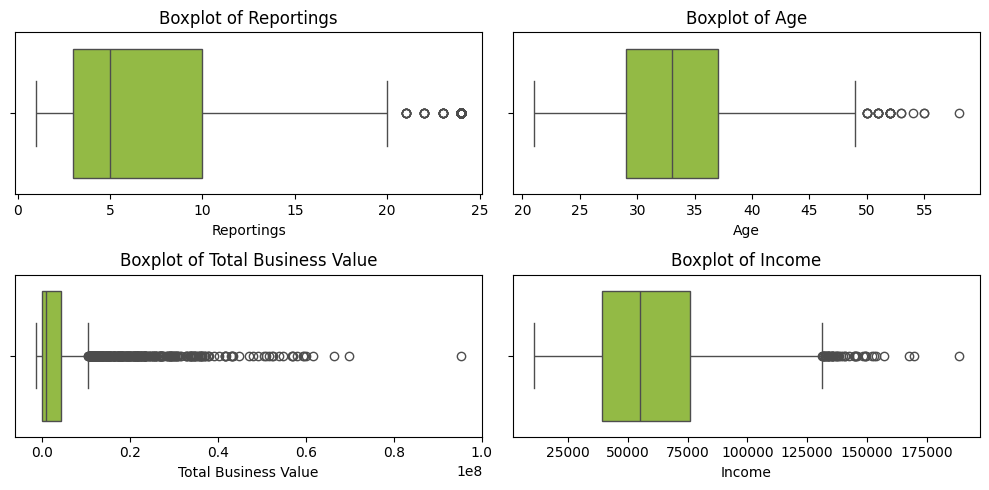

In [40]:
fig = plt.figure(figsize=(10,5))
i=1
for col in num_cols:
  ax = plt.subplot(2,2,i)
  sns.boxplot(x=df2[col],color='yellowgreen')
  plt.title(f'Boxplot of {col}')
  i += 1

plt.tight_layout()
plt.show()

Data is showing high outliers in Total Business value and Income

## EDA

In [47]:
data=df2.copy()


In [48]:
data.nunique()

,0
Reportings,24
Driver_ID,2381
Age,36
Gender,2
City,29
Education_Level,3
Dateofjoining,869
LastWorkingDate,493
Grade,5
Total Business Value,1629


In [50]:
data.describe()

,Reportings,Driver_ID,Age,Gender,Education_Level,Dateofjoining,LastWorkingDate,Grade,Total Business Value,Income,Joining Designation,Quarterly Rating,Target,Rating_incr,Income_incr
count,2381.00000,2381.000000,2381.000000,2381.000000,2381.00000,2381,1616,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,8.02352,1397.559009,33.663167,0.410332,1.00756,2019-01-27 12:58:58.009239808,2019-12-26 23:22:34.455445760,2.096598,4.586742e+06,59334.157077,1.820244,1.427971,0.678706,0.150357,0.018060
min,1.00000,1.000000,21.000000,0.000000,0.00000,2013-01-04 00:00:00,2018-12-31 00:00:00,1.000000,-1.385530e+06,10747.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,3.00000,695.000000,29.000000,0.000000,0.00000,2018-06-26 00:00:00,2019-06-10 00:00:00,1.000000,0.000000e+00,39104.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,5.00000,1400.000000,33.000000,0.000000,1.00000,2019-06-23 00:00:00,2019-12-20 12:00:00,2.000000,8.176800e+05,55315.000000,2.000000,1.000000,1.000000,0.000000,0.000000
75%,10.00000,2100.000000,37.000000,1.000000,2.00000,2020-04-14 00:00:00,2020-07-14 00:00:00,3.000000,4.173650e+06,75986.000000,2.000000,2.000000,1.000000,0.000000,0.000000
max,24.00000,2788.000000,58.000000,1.000000,2.00000,2020-12-28 00:00:00,2020-12-28 00:00:00,5.000000,9.533106e+07,188418.000000,5.000000,4.000000,1.000000,1.000000,1.000000
std,6.78359,806.161628,5.983375,0.491997,0.81629,NaN,NaN,0.941522,9.127115e+06,28383.666384,0.841433,0.809839,0.467071,0.357496,0.133195


In [51]:
cat_cols=['Gender','Education_Level','Grade','Joining Designation','Quarterly Rating','Rating_incr','Income_incr','Target']

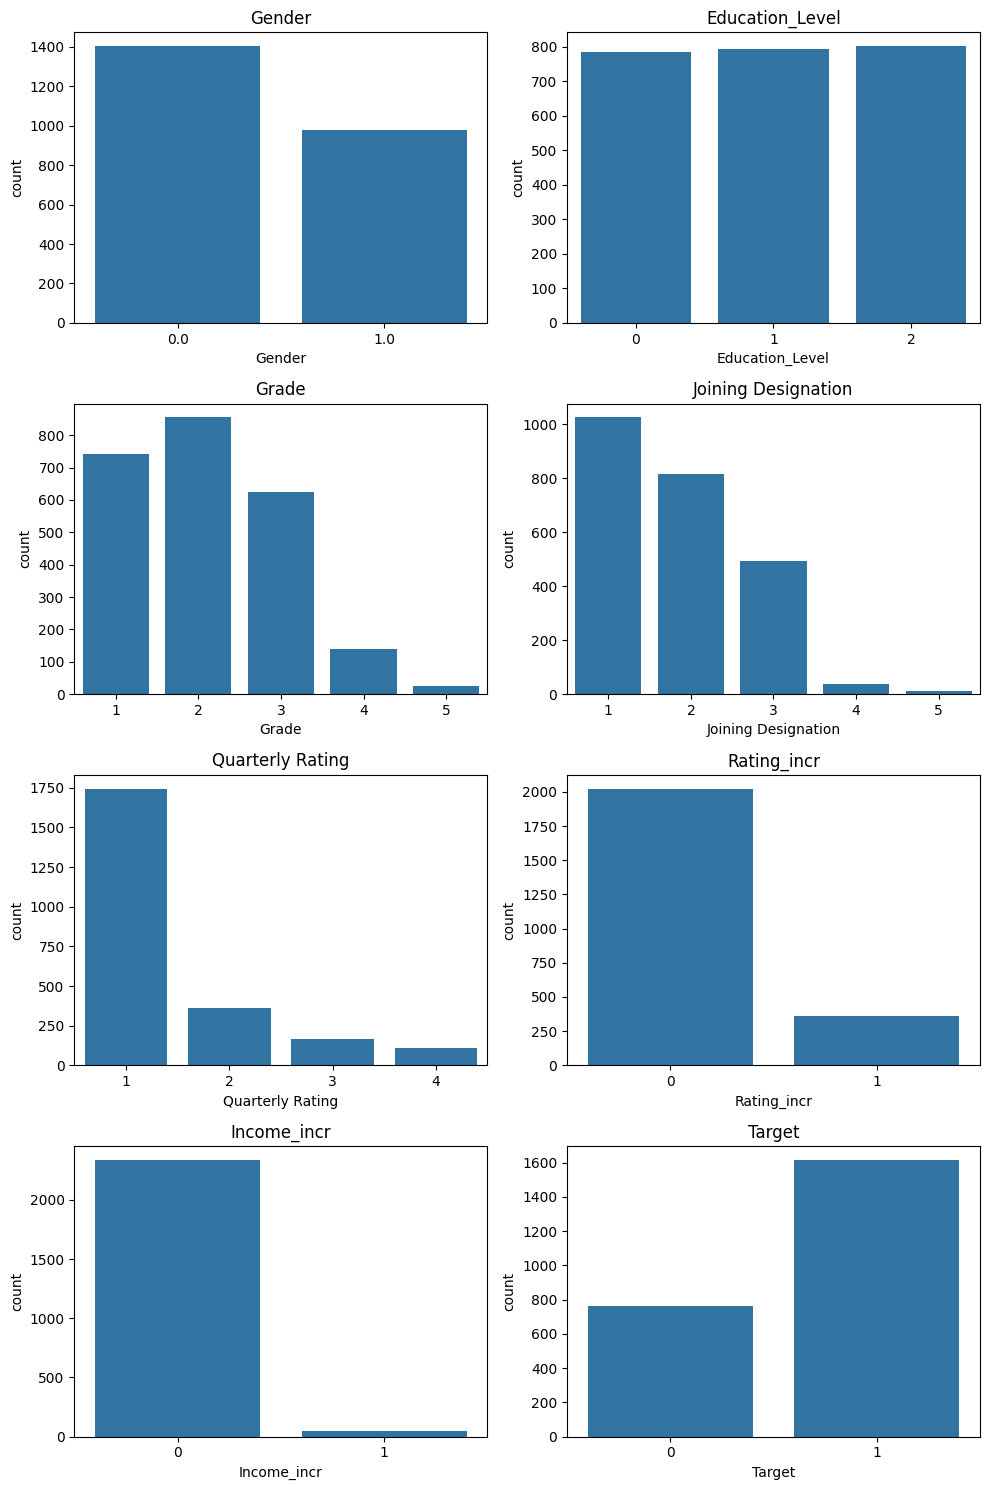

In [52]:
plt.figure(figsize=(10,15))
i=1
for col in cat_cols:
  ax=plt.subplot(4,2,i)
  sns.countplot(x=df2[col])
  plt.title(f'{col}')
  i += 1

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of City')

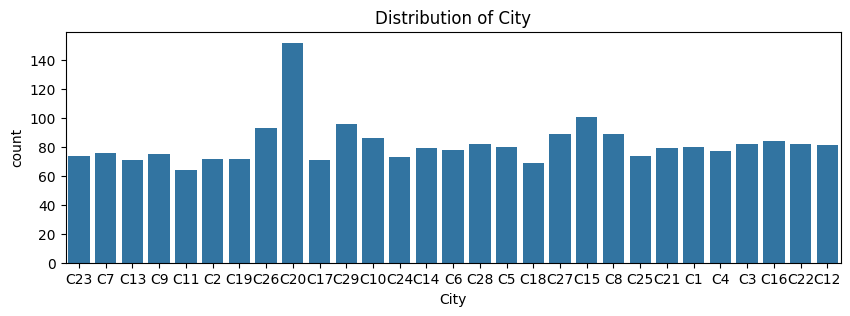

In [53]:
plt.figure(figsize=(10,3))
sns.countplot(x=df2['City'])
plt.title('Distribution of City')

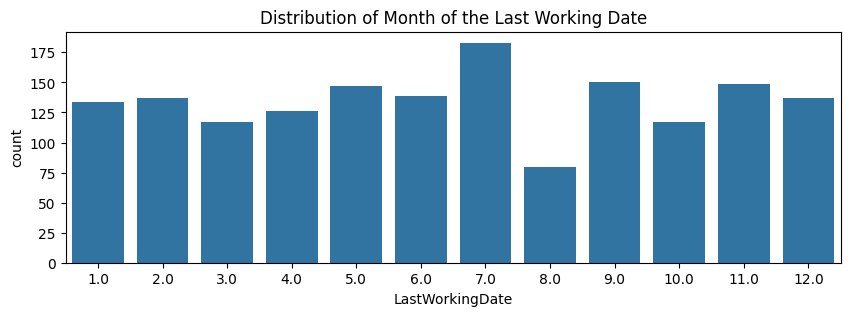

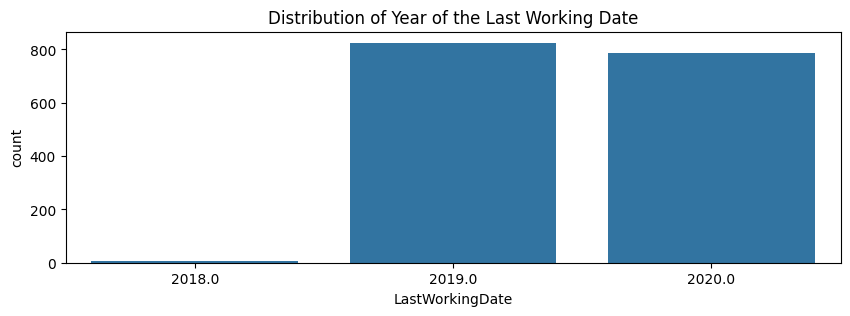

In [54]:
plt.figure(figsize=(10,3))
sns.countplot(x=df2['LastWorkingDate'].dt.month)
plt.title('Distribution of Month of the Last Working Date')

plt.figure(figsize=(10,3))
sns.countplot(x=df2['LastWorkingDate'].dt.year)
plt.title('Distribution of Year of the Last Working Date')

plt.show()

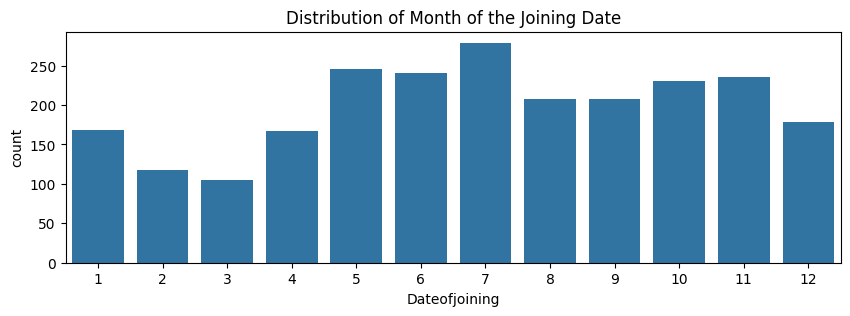

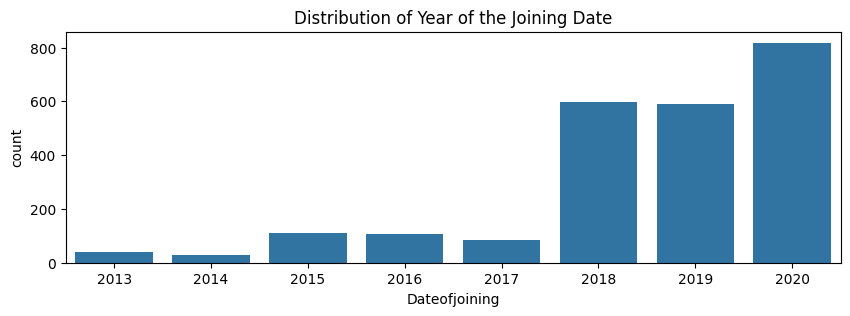

In [55]:
plt.figure(figsize=(10,3))
sns.countplot(x=df2['Dateofjoining'].dt.month)
plt.title('Distribution of Month of the Joining Date')

plt.figure(figsize=(10,3))
sns.countplot(x=df2['Dateofjoining'].dt.year)
plt.title('Distribution of Year of the Joining Date')

plt.show()

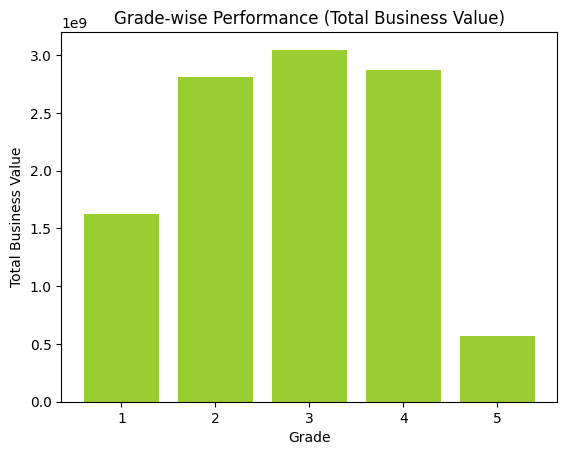

In [56]:

grade_wise_value = df2.groupby('Grade')['Total Business Value'].sum()

# Create the plot
plt.bar(grade_wise_value.index, grade_wise_value.values,color='yellowgreen')
plt.xlabel('Grade')
plt.ylabel('Total Business Value')
plt.title('Grade-wise Performance (Total Business Value)')
plt.show()


City with most improvement in Grade rating

In [57]:
data1=df.copy()

In [59]:
## with respect to the year of the last reporting Date

data1['Reporting_Date'] = pd.to_datetime(data1['Reporting_Date'])


last_date = data1['Reporting_Date'].max()
one_year_ago = last_date - pd.DateOffset(years=1)


df_past_year = data1[data1['Reporting_Date'] >= one_year_ago]


if df_past_year.empty:
    raise ValueError("No data available for the past year. Please check the date range or the data.")


rating_change = df_past_year.groupby('City').agg(
    start_rating=('Quarterly Rating', 'first'),
    end_rating=('Quarterly Rating', 'last')
).reset_index()


rating_change['rating_improvement'] = rating_change['end_rating'] - rating_change['start_rating']

In [61]:
if rating_change.empty or rating_change['rating_improvement'].isnull().all():
    raise ValueError("No improvements found. Please check the data.")


most_improved_city = rating_change.loc[rating_change['rating_improvement'].idxmax(), 'City']

print(f'The city with the most improvement in Quarterly Rating over the past year is: {most_improved_city}')


The city with the most improvement in Quarterly Rating over the past year is: C22


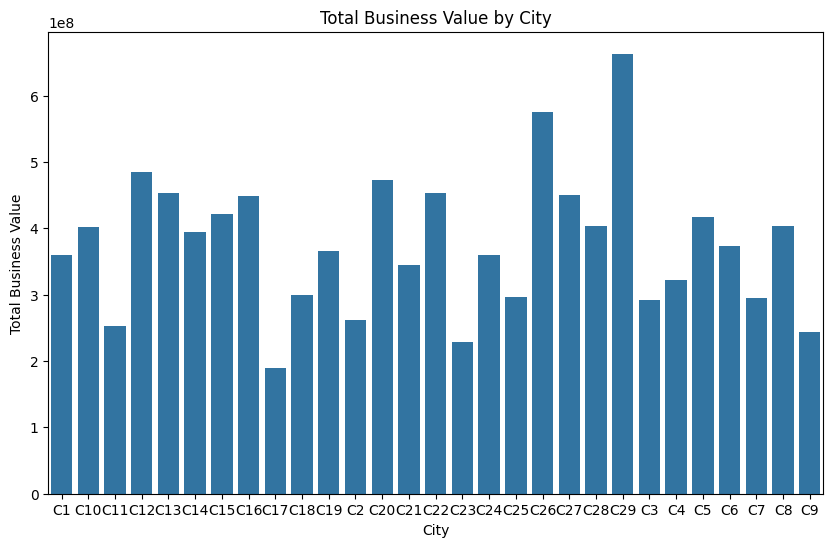

In [63]:
#Total business value x city

city_tbv = data1.groupby('City')['Total Business Value'].sum().reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(data=city_tbv, x='City', y='Total Business Value')

# Add title and labels
plt.title('Total Business Value by City')
plt.xlabel('City')
plt.ylabel('Total Business Value')
plt.show()

Impact of Each column on churn

In [65]:
cat1_cols=['Gender','Education_Level','Grade','Joining Designation','Quarterly Rating','Rating_incr','Income_incr']

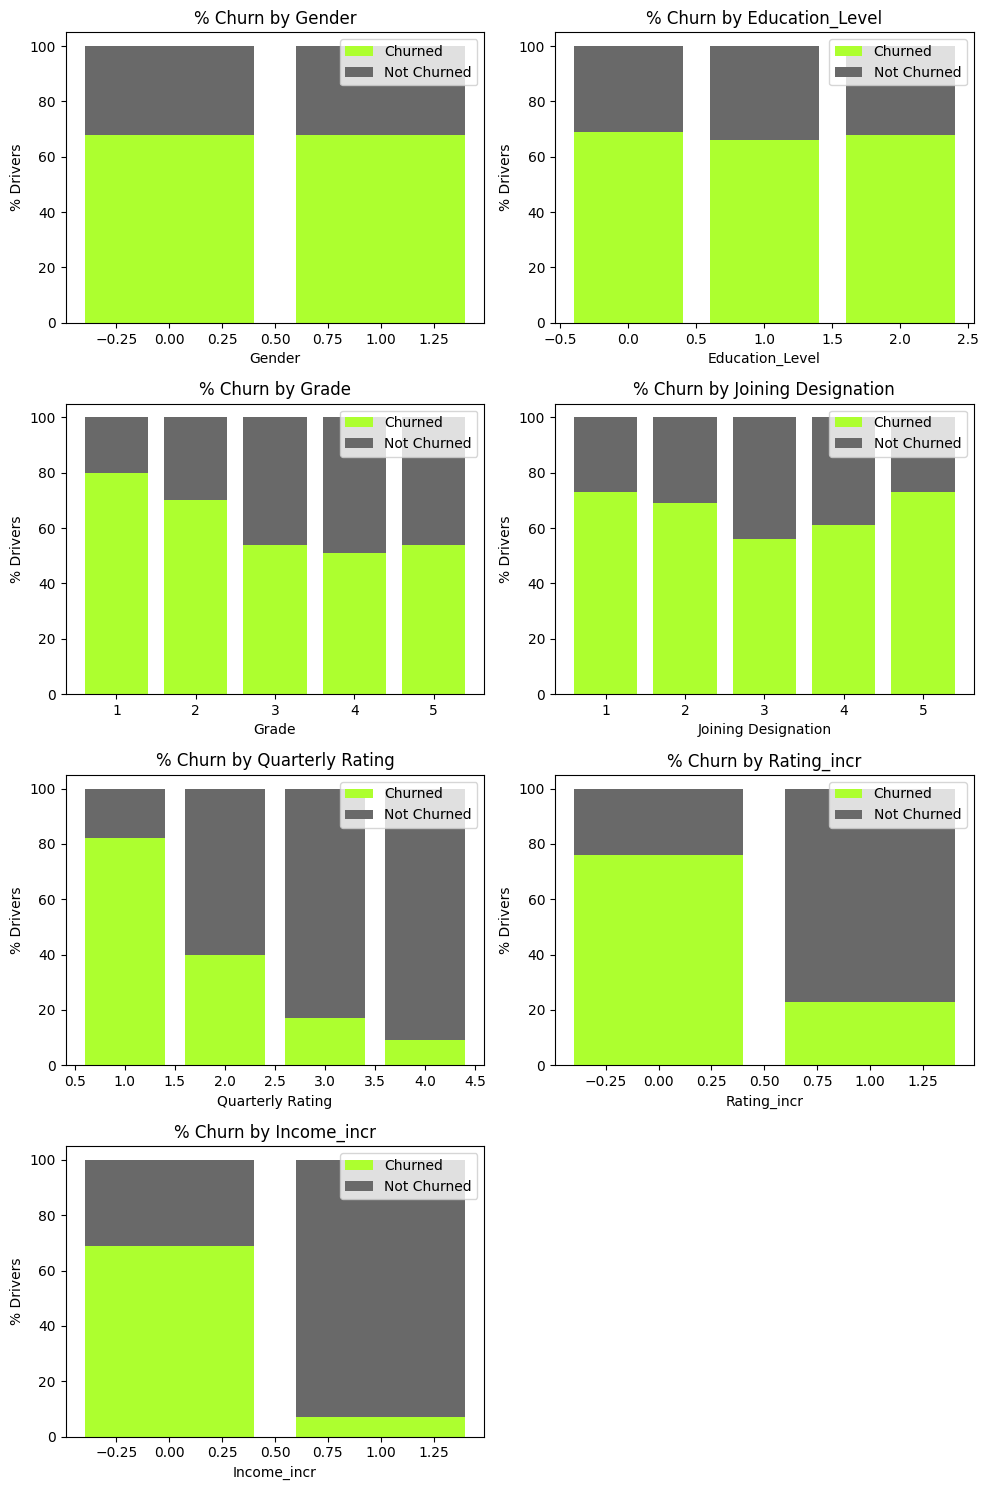

In [66]:

plt.figure(figsize=(10,15))
i=1
for col in cat1_cols:
    ax = plt.subplot(4, 2, i)

    data = df2.pivot_table(index=col, columns='Target', aggfunc='size')

    # Convert counts to percentages
    data = data.div(data.sum(axis=1), axis=0).multiply(100).round()
    data.reset_index(inplace=True)

    # Plotting the bars
    plt.bar(data[col], data[1], color='greenyellow',label='Churned')
    plt.bar(data[col], data[0], color='dimgrey', bottom=data[1],label='Not Churned')

    # Labeling and titles
    plt.xlabel(f'{col}')
    plt.ylabel('% Drivers')
    plt.title(f'% Churn by {col}')
    plt.legend(['Churned', 'Not Churned'])

    i += 1

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

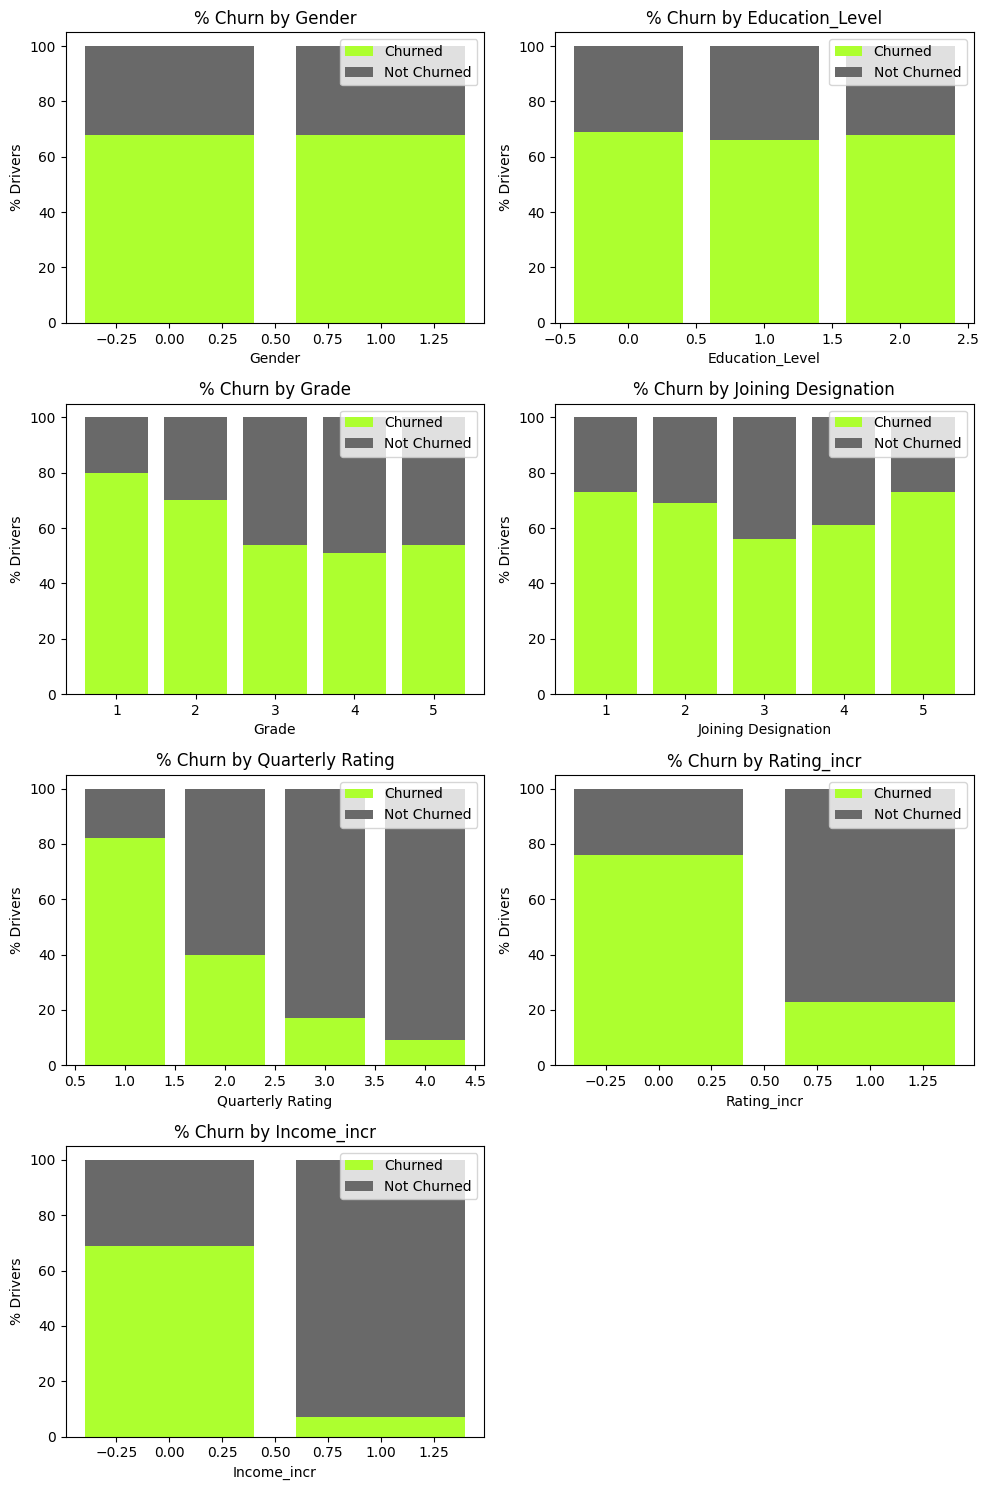

In [68]:

plt.figure(figsize=(10,15))
i=1
for col in cat1_cols:
    ax = plt.subplot(4, 2, i)

    data = df2.pivot_table(index=col, columns='Target', aggfunc='size')

    # Convert counts to percentages
    data = data.div(data.sum(axis=1), axis=0).multiply(100).round()
    data.reset_index(inplace=True)

    # Plotting the bars
    plt.bar(data[col], data[1], color='greenyellow',label='Churned')
    plt.bar(data[col], data[0], color='dimgrey', bottom=data[1],label='Not Churned')

    # Labeling and titles
    plt.xlabel(f'{col}')
    plt.ylabel('% Drivers')
    plt.title(f'% Churn by {col}')
    plt.legend(['Churned', 'Not Churned'])

    i += 1

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [69]:
 city = df2.pivot_table(index='City', columns='Target', aggfunc='size')
    city = city.div(city.sum(axis=1), axis=0).multiply(100).round()
    city.reset_index(inplace=True)
    city = city.sort_values(by=1, ascending=False)

    plt.figure(figsize=(14,4))
    plt.bar(city['City'], city[1], color='greenyellow')
    plt.bar(city['City'], city[0], color='dimgrey', bottom=city[1])

    # Labeling and titles
    plt.xlabel('City')
    plt.ylabel('% Drivers')
    plt.title(f'% Churn by City')
    plt.legend(['Churned', 'Not Churned'])
    plt.xticks(rotation=90)
    plt.show()

IndentationError: unexpected indent (<ipython-input-69-9d8f47c6fb00>, line 2)

Key notes:

Key Insights on Driver Churn:

* Gender and education level don’t seem to have any impact on churn.
* Grade 1 drivers had the highest churn rate at 80%, followed by Grade 2 at around 70%.
* The highest churn was seen among drivers who started with Designation 1 and 5, with nearly 75% leaving.
* Quarterly Rating appears to influence churn: 80% of those with a QR1 rating left, followed by 40% of QR2 and about 18% of QR3.
* Around 77% of drivers who didn’t see any improvement in their rating ended up leaving.
* Income growth also played a role—70% of those who didn’t get a raise decided to quit.
* Location mattered too—80% of drivers from City C13 left, with C17 and C23 not far behind.

